<a href="https://colab.research.google.com/github/illNO/nlp/blob/main/Bert_tweet_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 194kB 18.3MB/s 
     |████████████████████████████████| 245kB 43.5MB/s 
     |████████████████████████████████| 112kB 56.2MB/s 
     |████████████████████████████████| 2.0MB 17.2MB/s 
     |████████████████████████████████| 3.2MB 54.1MB/s 
     |████████████████████████████████| 890kB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=173dd713b05604f6236262059a78f79e836e29372d0f76e9ba63da1f84f7071b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# import nlp
import datasets
from datasets import load_dataset
import numpy as np
import transformers
from sklearn.metrics import accuracy_score

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [4]:
tokenizer.tokenize("Hello, world!")

['hello', ',', 'world', '!']

In [5]:
bert = transformers.AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
bert

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [6]:
tweets = load_dataset('tweet_eval', 'sentiment')

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/79e21f7659e902ea14f624232219492d972fe5e0f9d8c94363acc7f916a6be48. Subsequent calls will reuse this data.


In [7]:
tweets.shape

{'test': (12284, 2), 'train': (45615, 2), 'validation': (2000, 2)}

In [8]:
set(tweets['test']['label'])

{0, 1, 2}

# For sentiment config:

- text: a string feature containing the tweet.

- label: an int classification label with the following mapping:

  0: negative

  1: neutral

  2: positive

In [9]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

train_data, test_data = datasets.load_dataset('tweet_eval', 'sentiment', split=['train', 'test'])
# train_data = train_data[:60000]

train_data = train_data.map(tokenize, batched=True, batch_size=len(train_data))
test_data = test_data.map(tokenize, batched=True, batch_size=len(train_data))

train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/79e21f7659e902ea14f624232219492d972fe5e0f9d8c94363acc7f916a6be48)


In [10]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc
  }

In [11]:
training_args = transformers.TrainingArguments(
    output_dir='./output',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    warmup_steps=500,
    logging_dir='./logs',
    evaluation_strategy='epoch'
)
trainer = transformers.Trainer(
    model = bert,
    args = training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data, 
    eval_dataset=test_data
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.673500,0.690813,0.689026,29.322300,418.931000
2,0.531200,0.688717,0.694888,29.439200,417.267000
3,0.428800,0.741719,0.692120,29.515800,416.184000


TrainOutput(global_step=4278, training_loss=0.5639283303737418, metrics={'train_runtime': 1671.9512, 'train_samples_per_second': 2.559, 'total_flos': 6377144249769480.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 351732, 'init_mem_gpu_alloc_delta': 268956160, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1150724, 'train_mem_gpu_alloc_delta': 837513728, 'train_mem_cpu_peaked_delta': 96355071, 'train_mem_gpu_peaked_delta': 1605967872})

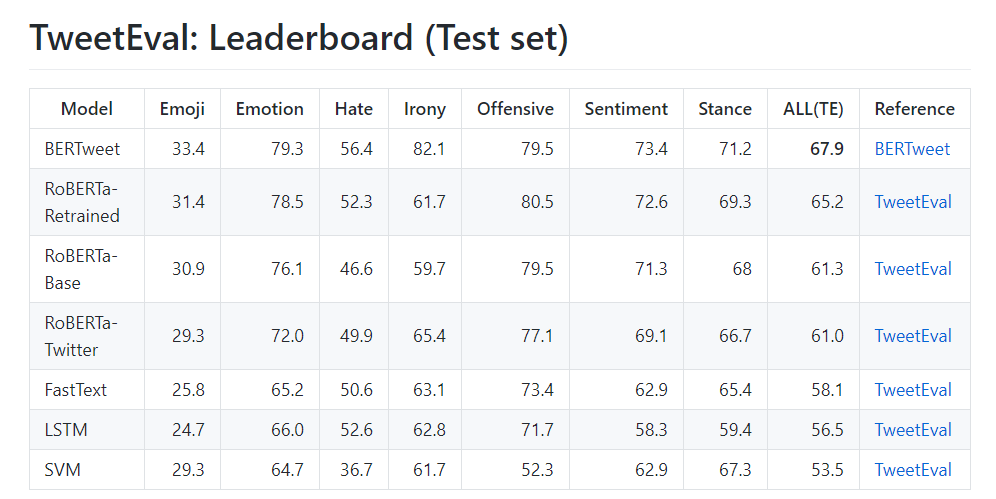